<a href="https://colab.research.google.com/github/snakeway8/Projects/blob/main/hr_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TASK:understand the company’s different segments of employees and give a recommentdations how to increase employee retention within each segment.

In [113]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

### 1.Data Prep

In [114]:
df = pd.read_csv('/content/employee_data.csv')

In [115]:
df.head()

,EmployeeID,Age,Gender,DistanceFromHome,JobLevel,Department,MonthlyIncome,PerformanceRating,JobSatisfaction,Attrition
0,1001,41,Female,1,2,Sales,5993,3,4,Yes
1,1002,49,Male,8,2,Research & Development,5130,4,2,No
2,1004,37,Male,2,1,Research & Development,2090,3,3,Yes
3,1005,33,Female,3,1,Research & Development,2909,3,3,No
4,1007,27,Male,2,1,Research & Development,3468,3,2,No


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   EmployeeID         1470 non-null   int64 
 1   Age                1470 non-null   int64 
 2   Gender             1470 non-null   object
 3   DistanceFromHome   1470 non-null   int64 
 4   JobLevel           1470 non-null   int64 
 5   Department         1470 non-null   object
 6   MonthlyIncome      1470 non-null   int64 
 7   PerformanceRating  1470 non-null   int64 
 8   JobSatisfaction    1470 non-null   int64 
 9   Attrition          1470 non-null   object
dtypes: int64(7), object(3)
memory usage: 115.0+ KB


In [117]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0}).astype(int)
df['Gender'] = np.where(df['Gender']=='Male',1,0).astype(int)

2.EDA

In [118]:
df['Gender'].value_counts()

,count
Gender,
1,882
0,588


In [119]:
df.Department.value_counts()

,count
Department,
Research & Development,961
Sales,446
Human Resources,63


In [120]:
data = df[['Age', 'Gender', 'DistanceFromHome', 'JobLevel','MonthlyIncome', 'PerformanceRating', 'JobSatisfaction',
       'Attrition']]

In [121]:
#the mean of each column for employees who stay vs leave

df[['Age', 'Gender', 'DistanceFromHome', 'JobLevel','MonthlyIncome', 'PerformanceRating', 'JobSatisfaction',
       'Attrition']].groupby('Attrition').mean().round(2)

,Age,Gender,DistanceFromHome,JobLevel,MonthlyIncome,PerformanceRating,JobSatisfaction
Attrition,,,,,,,
0,37.56,0.59,8.92,2.15,6832.74,3.15,2.78
1,33.61,0.63,10.63,1.64,4787.09,3.16,2.47


 People who stay tend to be older, female, live close by, more senior, are happy with their jobs and work in research & development

In [122]:
#Exclude the attrition  and department columns (to be overlayed onto our clusters later on)
data = df[['Age', 'Gender', 'DistanceFromHome', \
           'JobLevel','MonthlyIncome', 'PerformanceRating', 'JobSatisfaction']]

In [123]:
data.head()

,Age,Gender,DistanceFromHome,JobLevel,MonthlyIncome,PerformanceRating,JobSatisfaction
0,41,0,1,2,5993,3,4
1,49,1,8,2,5130,4,2
2,37,1,2,1,2090,3,3
3,33,0,3,1,2909,3,3
4,27,1,2,1,3468,3,2


In [124]:
data.shape

(1470, 7)

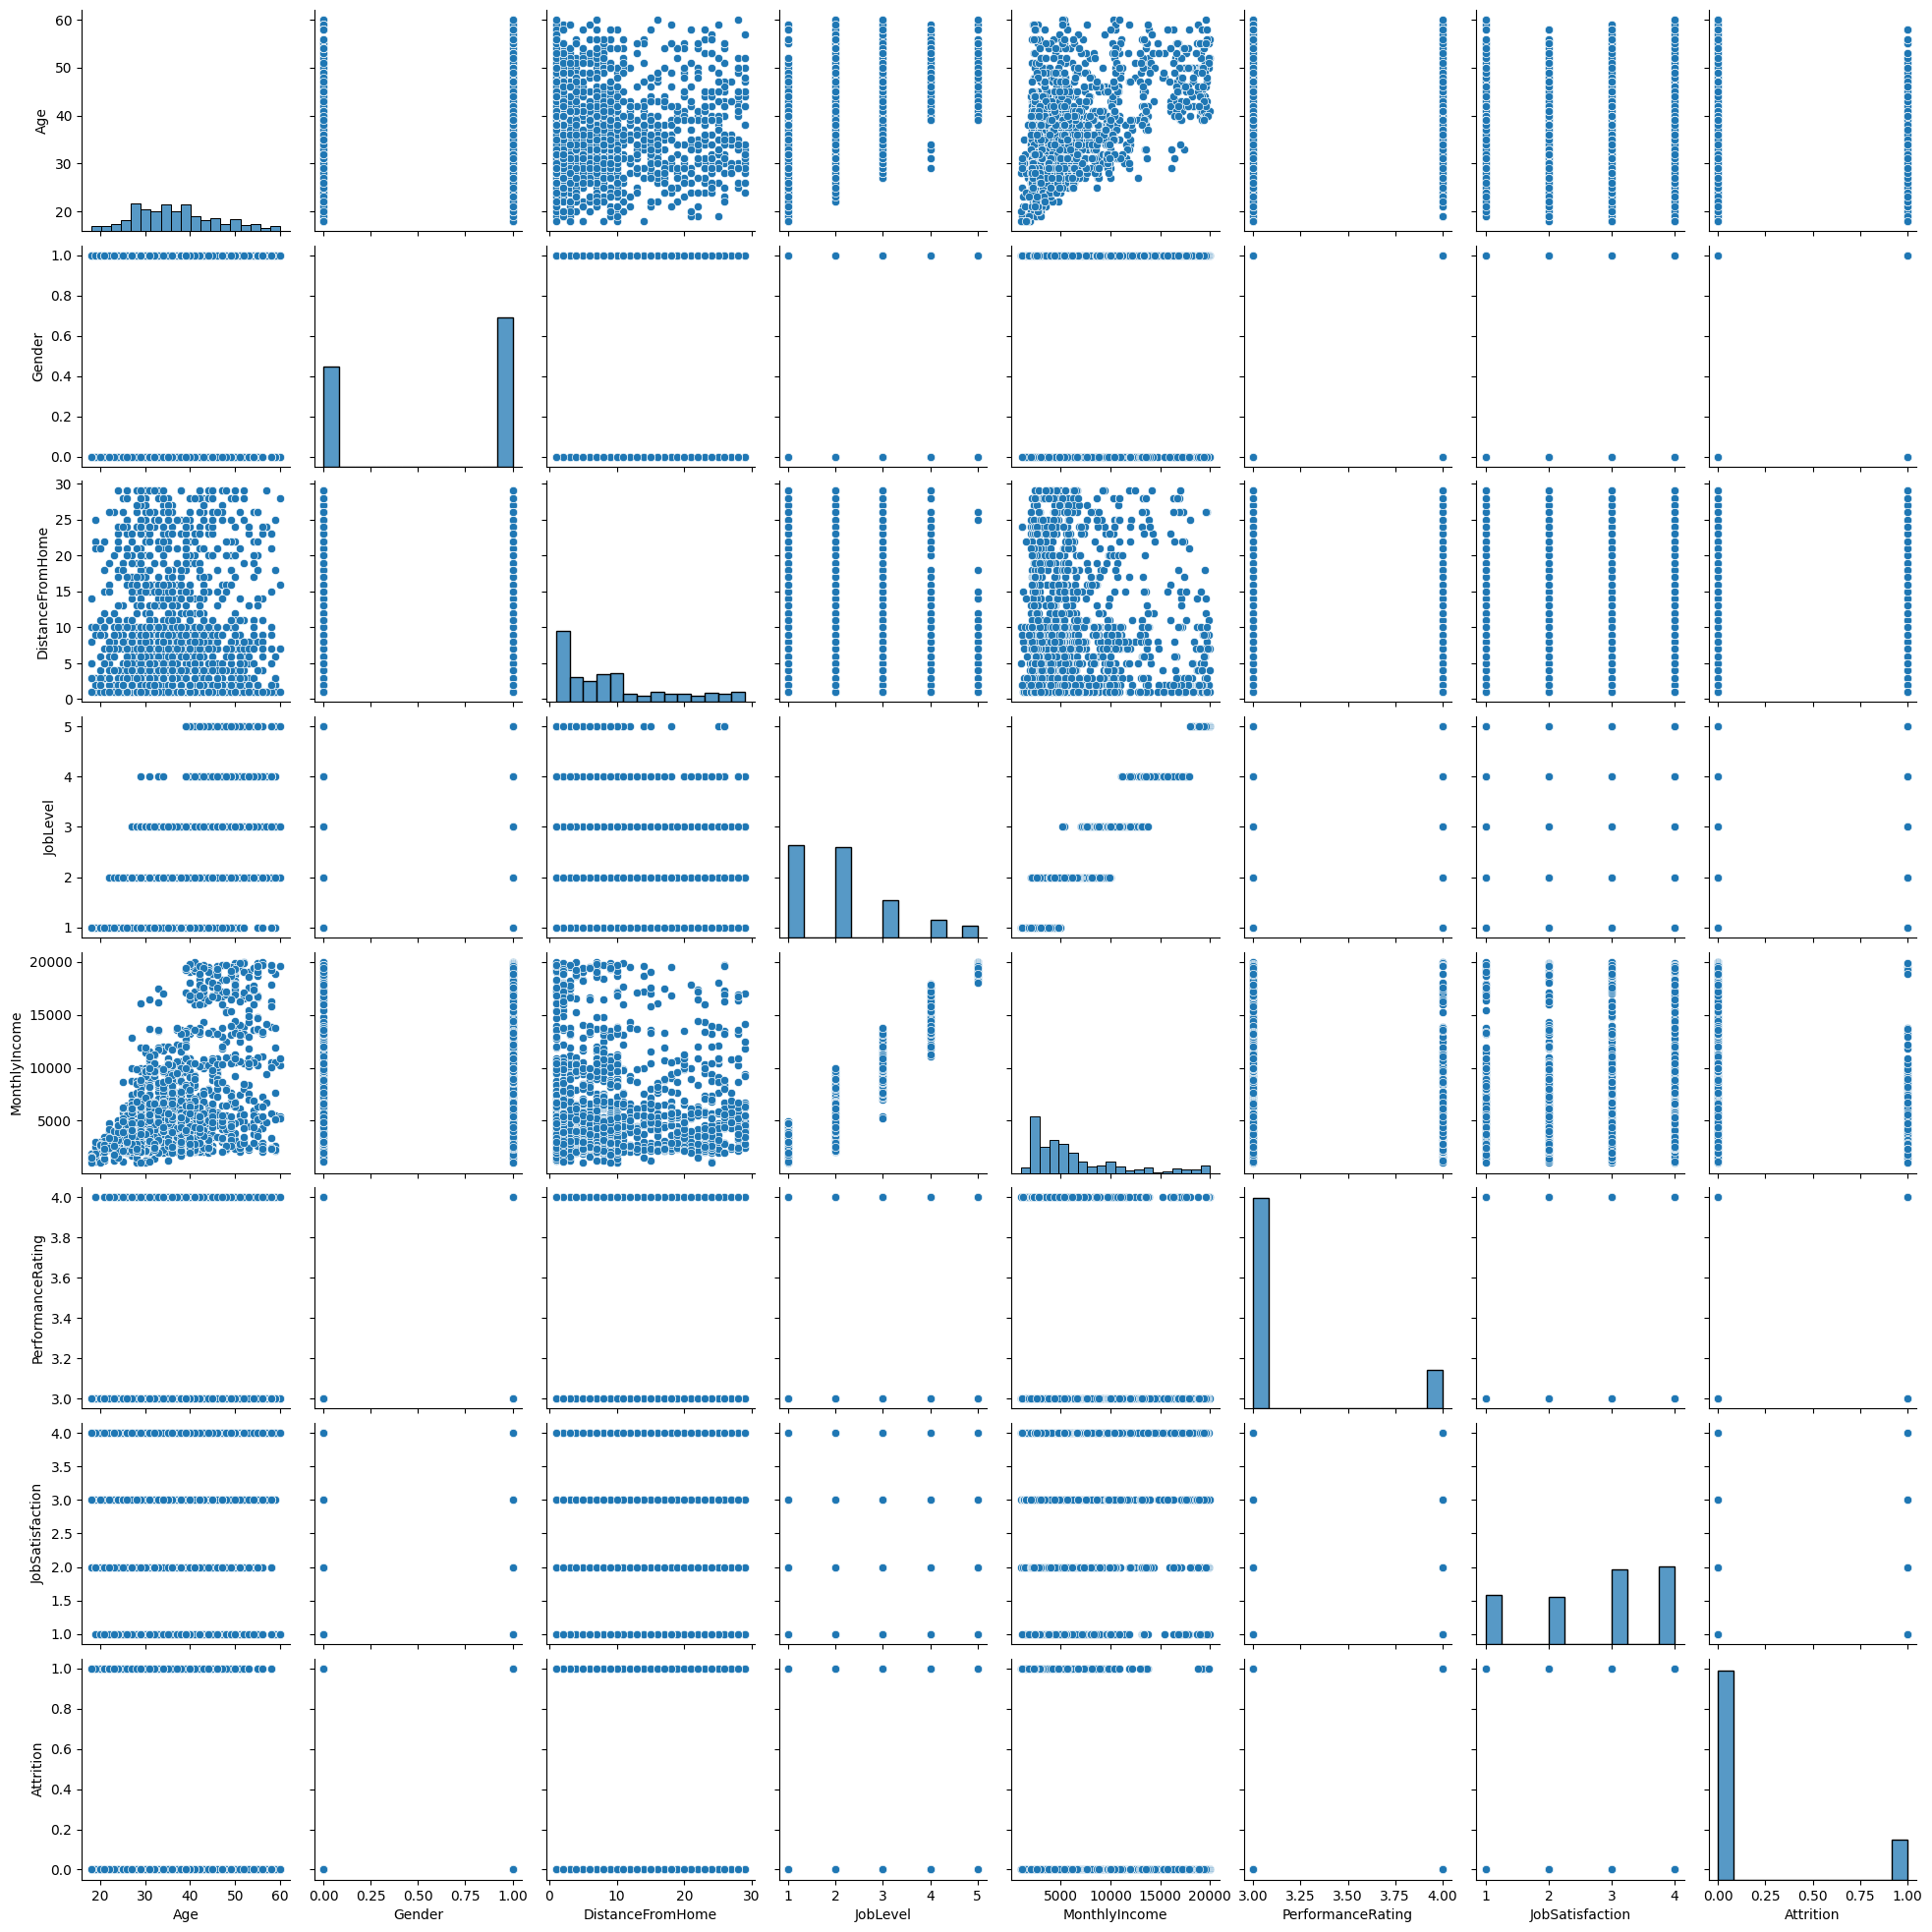

In [125]:
import seaborn as sns

sns.pairplot(df.iloc[:,1:])

OBSERVATIONS:

-Age and gender seem to be pretty evenly distributed

-More people live closer to the office

-Job level and income are correlated

-There are fewer high performers

-Most people are happy with the jobs

-There are few people in HR compared to the other departments

### 2. K-Means Clustering

In [126]:
# scale the data using standardization

scaler = StandardScaler()

# Fit and transform the DataFrame
scaled_model_df = scaler.fit_transform(data)

# Convert the result back into a DataFrame with the original column names
scaled_df = pd.DataFrame(scaled_model_df, columns=data.columns)

In [127]:
scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,-3.504377e-17,1.00034,-2.072192,-0.758170,-0.101159,0.665354,2.526886
Gender,1470.0,4.350262e-17,1.00034,-1.224745,-1.224745,0.816497,0.816497,0.816497
DistanceFromHome,1470.0,4.350262e-17,1.00034,-1.010909,-0.887515,-0.270544,0.593216,2.444129
JobLevel,1470.0,-2.658493e-17,1.00034,-0.961486,-0.961486,-0.057788,0.845911,2.653309
MonthlyIncome,1470.0,-4.471102e-17,1.00034,-1.167343,-0.763209,-0.336552,0.398625,2.867626
PerformanceRating,1470.0,-6.114534e-16,1.00034,-0.426230,-0.426230,-0.426230,-0.426230,2.346151
JobSatisfaction,1470.0,-9.183886e-17,1.00034,-1.567907,-0.660853,0.246200,1.153254,1.153254


In [128]:
inertia_values = []

# create 2 - 15 clusters, and add the intertia scores
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42) # changed from auto to 10
    kmeans.fit(scaled_df)
    inertia_values.append(kmeans.inertia_)


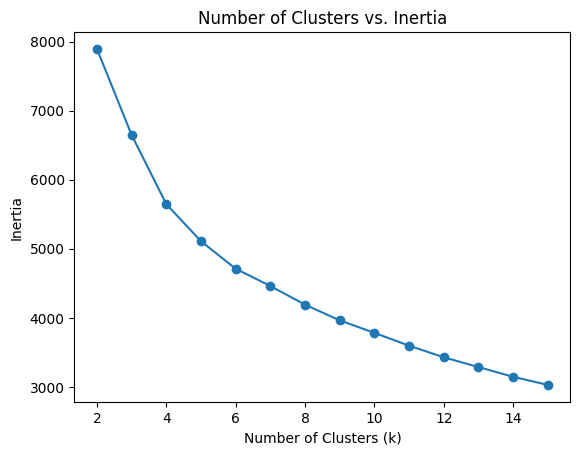

In [129]:
inertia_series_v2 = pd.Series(inertia_values, index=range(2, 16))

# plot the data
inertia_series_v2.plot(marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Number of Clusters vs. Inertia");

In [130]:
 #k=6
 #fit a kmeans model
kmeans6 = KMeans(n_clusters=6, n_init=10, random_state=42)
kmeans6.fit(scaled_df)

KMeans(n_clusters=6, n_init=10, random_state=42)

In [131]:
#  the number of employees in each cluster
from collections import Counter
Counter(kmeans6.labels_)

Counter({3: 349, 1: 200, 0: 304, 5: 201, 2: 197, 4: 219})

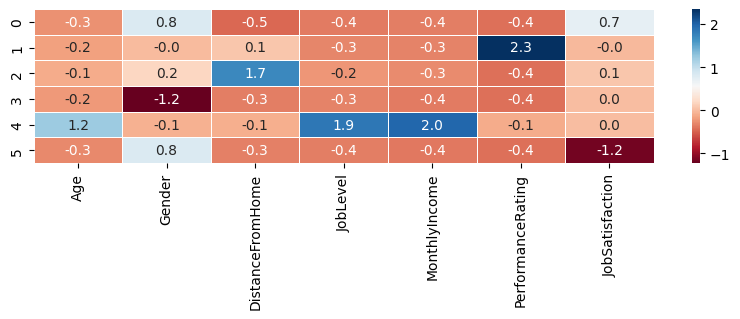

In [132]:
cluster_centers6= pd.DataFrame(kmeans6.cluster_centers_, columns=scaled_df.columns)

plt.figure(figsize=(10, 2))
sns.heatmap(cluster_centers6, annot=True, cmap="RdBu", fmt=".1f", linewidths=.5);

Interpret the clusters:
* Cluster 0: men who like their job
* Cluster 1: high performers
* Cluster 2: long distance from home
* Cluster 3: women
* Cluster 4: senior employee with high income
* Cluster 5: men who dislike their job

### EDA on  Clusters

In [133]:
cluster_mapping = {0: 'Men who like their job',
                   1: 'High performers employees',
                   2: 'Long distance from home',
                   3: 'Female employees',
                   4: 'Senior employees with high income',
                   5: 'Men who dislike their job'}

In [134]:
df.loc[:, 'cluster'] = kmeans6.labels_

In [135]:
df['cluster'] = df['cluster'].map(cluster_mapping)

In [137]:
#View the attrition rates for each cluster

df.groupby(['cluster'])['Attrition'].mean().sort_values(ascending=False)

,Attrition
cluster,
Long distance from home,0.218274
Men who dislike their job,0.189055
High performers employees,0.185000
Men who like their job,0.161184
Female employees,0.154728
Senior employees with high income,0.073059


* Employees witch have  long distance from home are most likely to leave
* Senior employees are most likely to stay

In [139]:
df.head()

,EmployeeID,Age,Gender,DistanceFromHome,JobLevel,Department,MonthlyIncome,PerformanceRating,JobSatisfaction,Attrition,cluster
0,1001,41,0,1,2,Sales,5993,3,4,1,Female employees
1,1002,49,1,8,2,Research & Development,5130,4,2,0,High performers employees
2,1004,37,1,2,1,Research & Development,2090,3,3,1,Men who like their job
3,1005,33,0,3,1,Research & Development,2909,3,3,0,Female employees
4,1007,27,1,2,1,Research & Development,3468,3,2,0,Men who dislike their job


In [141]:
#View the department breakdown for each cluster
df.groupby(['cluster', 'Department']).agg(
    number_people=('EmployeeID', 'count'),
    mean_attrition=('Attrition', 'mean'))

number_people  \
cluster                           Department                              
Female employees                  Human Resources                    10   
                                  Research & Development            223   
                                  Sales                             116   
High performers employees         Human Resources                     7   
                                  Research & Development            138   
                                  Sales                              55   
Long distance from home           Human Resources                     6   
                                  Research & Development            130   
                                  Sales                              61   
Men who dislike their job         Human Resources                    14   
                                  Research & Development            122   
                                  Sales                              65   
Men who like their job            Human Resources                    14   
                                  Research & Development            197   
                                  Sales                              93   
Senior employees with high income Human Resources                    12   
                                  Research & Development            151   
                                  Sales                              56   

                                                          mean_attrition  
cluster                           Department                              
Female employees                  Human Resources               0.300000  
                                  Research & Development        0.121076  
                                  Sales                         0.206897  
High performers employees         Human Resources               0.142857  
                                  Research & Development        0.188406  
                                  Sales                         0.181818  
Long distance from home           Human Resources               0.666667  
                                  Research & Development        0.153846  
                                  Sales                         0.311475  
Men who dislike their job         Human Resources               0.214286  
                                  Research & Development        0.172131  
                                  Sales                         0.215385  
Men who like their job            Human Resources               0.071429  
                                  Research & Development        0.152284  
                                  Sales                         0.193548  
Senior employees with high income Human Resources               0.000000  
                                  Research & Development        0.059603  
                                  Sales                         0.125000

* The groups most likely to leave are people with long distance from home (especially 6 people from HR department)
* The groups most likely NOT to leave are senior employees, men who like their jobs

### Recommendations  to retain employees in each cluster
Higher attrition:
* Long distanse from home: find remote options, create a more inclusive remote culture
* Men who dislike their jobs: have their managers have conversations with them
* Higher performers: find opportunities for more senior positions

Lower attrition:

* Senior employees: this makes sense that they have less attrition since they've been around a long time
* Female employees: this is an interesting finding,we need more detail information
* Men who like their jobs: this make sense that people who like their job would stay